# DATA C88C (Fall 2025) Ants Project EDA

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


import sqlite3
import json

In [2]:
# Connect to the database
DB_PATH = "../../data/private/data_c88c_fa25.db"
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

## How many students are there with Ants backups?

In [4]:
cursor.execute("SELECT COUNT(DISTINCT student_email) FROM backup_metadata")
num_students = cursor.fetchone()[0]
num_students

470

## How many backups are there total?

In [5]:
cursor.execute("SELECT COUNT(*) FROM backup_metadata")
num_backups_total = cursor.fetchone()[0]
num_backups_total

33323

## How many backups are there per student?

In [6]:
cursor.execute("SELECT COUNT(*) FROM backup_metadata GROUP BY student_email")
num_backups_per_student = np.array([row[0] for row in cursor.fetchall()])

In [7]:
np.min(num_backups_per_student)

np.int64(1)

In [8]:
np.mean(num_backups_per_student)

np.float64(70.9)

In [9]:
np.median(num_backups_per_student)

np.float64(65.0)

In [10]:
# NOTE: When retrieving backups, we set a limit of 150 backups,
# so there is likely a ceiling effect here
np.max(num_backups_per_student)

np.int64(150)

<Axes: ylabel='Count'>

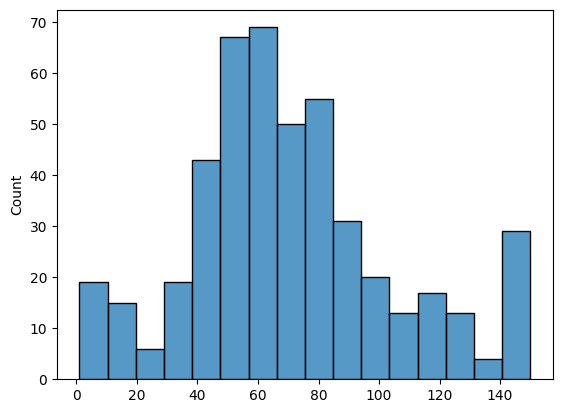

In [11]:
sns.histplot(num_backups_per_student)

## When did students start/finish the assignment? (first backup timestamp vs. last backup timestamp)

In [12]:
cursor.execute("""
    SELECT MIN(created) AS first_created
    FROM backup_metadata
    GROUP BY student_email
""")
first_backup_dates = np.array([row[0] for row in cursor.fetchall()]).astype('datetime64[s]')

In [13]:
cursor.execute("""
    SELECT MAX(created) AS first_created
    FROM backup_metadata
    GROUP BY student_email
""")
last_backup_dates = np.array([row[0] for row in cursor.fetchall()]).astype('datetime64[s]')

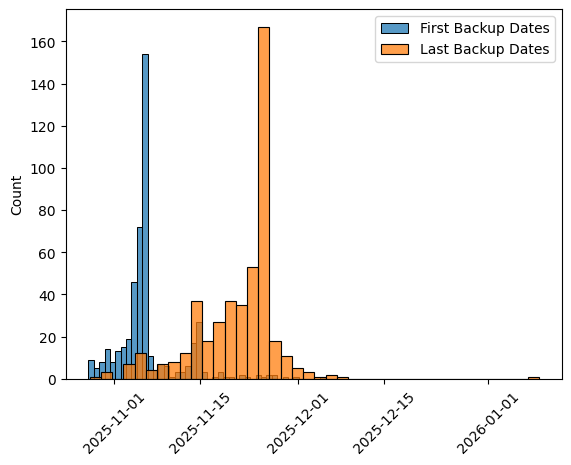

In [14]:
sns.histplot(first_backup_dates, label='First Backup Dates')
sns.histplot(last_backup_dates, label='Last Backup Dates')
plt.xticks(rotation=45)
plt.legend()

In FA25, Ants was released 10/27 and due 11/25. To make the histogram easier to interpret, we exclude students who ended after 12/1.

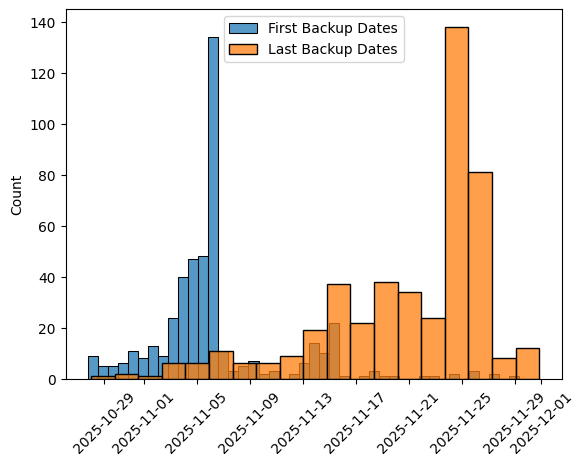

In [15]:
mask = last_backup_dates <= np.datetime64('2025-12-01')
sns.histplot(first_backup_dates[mask], label='First Backup Dates')
sns.histplot(last_backup_dates[mask], label='Last Backup Dates')
plt.xticks(rotation=45)
plt.legend()

## What is the total time spent on the assignment (last backup timestamp - first backup timestamp)

In [16]:
cursor.execute("""
    SELECT
        student_email,
        MIN(created) AS first_created,
        MAX(created) AS last_created,
        (julianday(MAX(created)) - julianday(MIN(created))) * 24 * 60 * 60 as diff_seconds
    FROM backup_metadata
    GROUP BY student_email
""")
total_duration_sec = np.array([row[3] for row in cursor.fetchall()])

Note: We convert back to total duration in days for better interpretability here

In [17]:
total_duration_days = total_duration_sec / (24 * 60 * 60)

In [18]:
np.min(total_duration_days)

np.float64(0.0)

In [19]:
np.mean(total_duration_days)

np.float64(14.744731579984519)

In [20]:
np.median(total_duration_days)

np.float64(17.11336805555038)

In [21]:
np.max(total_duration_days)

np.float64(58.196574073750526)

<Axes: ylabel='Count'>

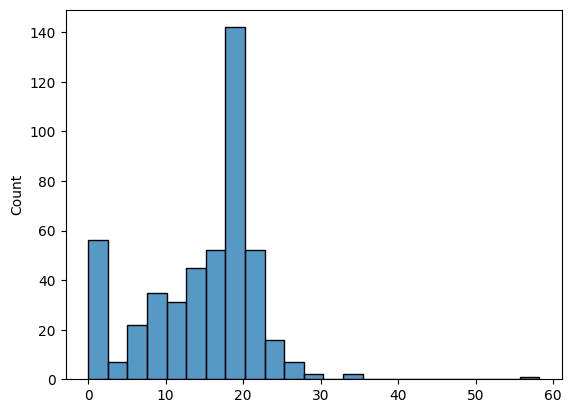

In [22]:
sns.histplot(total_duration_days)

Examine the histogram eliminating outliers. From eyeballing, most students took 40 days or less to do the assignment.

<Axes: ylabel='Count'>

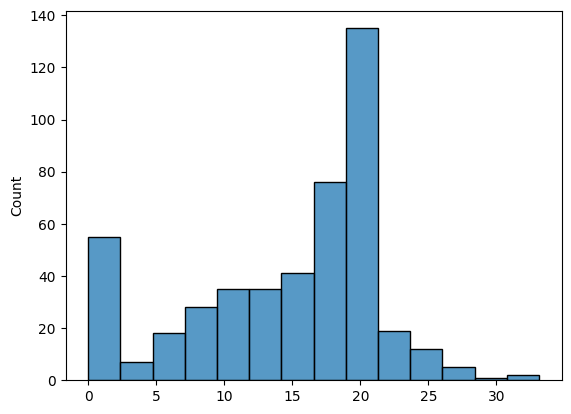

In [23]:
sns.histplot(total_duration_days[total_duration_days <= 40])

## How many problems did students solve by their last backup?

In [24]:
cursor.execute("""
WITH last_backups AS (
    SELECT
        student_email,
        backup_id,
        MAX(created) AS last_created
    FROM backup_metadata
    GROUP BY student_email
)

SELECT
    lb.*,
    history
FROM analytics_messages AS am
JOIN last_backups AS lb
ON am.backup_id = lb.backup_id
""")
last_backup_analytics_histories = [json.loads(row[3]) for row in cursor.fetchall()]
last_backup_analytics_histories[0]

[{'display_name': 'Problem 0', 'attempts': 1, 'solved': True},
 {'display_name': 'Problem 1', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 2', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 3', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 4', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 5', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 6', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 7', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 8a', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 8b', 'attempts': 3, 'solved': True},
 {'display_name': 'Problem 8c', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 9', 'attempts': 3, 'solved': True},
 {'display_name': 'Problem 10', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 11', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 12', 'attempts': 2, 'solved': True}]

In [25]:
def count_problems_solved(history: list[dict]) -> int:
    solved = 0
    for problem in history:
        if problem['solved']:
            solved += 1
    return solved

In [26]:
last_backup_problems_solved = np.array(list(map(count_problems_solved, last_backup_analytics_histories)))
last_backup_problems_solved[0]

np.int64(15)

It looks like this semester students attempted to do the optional problems (standard set contains 15 problems. There are 4 optional problems.)

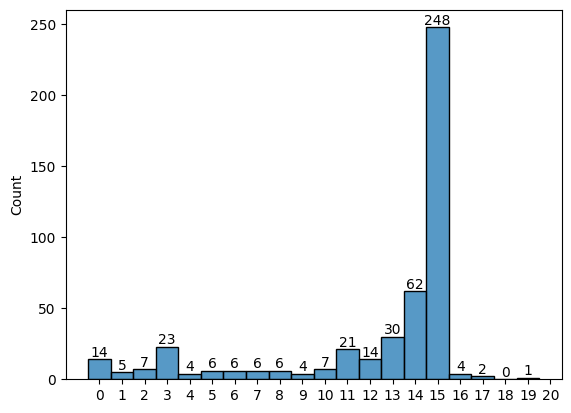

In [27]:
ax = sns.histplot(last_backup_problems_solved, discrete=True)
# Display counts at the top of each bar
ax.bar_label(ax.containers[0])
# Force xticks to be every 1 unit
ax.set_xticks(range(int(min(last_backup_problems_solved)), int(max(last_backup_problems_solved)) + 2))
plt.show()

## How many students did autograder spam, defined as >= 20 backups where each consecutive backup is < 5 min apart?

In [28]:
cursor.execute("""
WITH gaps AS (
    SELECT
        student_email,
        -- need this column so that we can create windows ordered by `created` column in CTE below
        created,
        -- Calculate the gap between current and previous
        (julianday(created) - LAG(julianday(created)) OVER (PARTITION BY student_email ORDER BY created)) * 24 * 60 AS gap_minutes
    FROM backup_metadata
),

groups_of_ten AS (
    SELECT
        student_email,
        MAX(gap_minutes) OVER w AS max_gap_in_window,
        -- window may be less than 10, e.g. if processing 1st row
        -- so we have to check the count later
        COUNT(*) OVER w AS num_backups
    FROM gaps
    WINDOW w AS (
        PARTITION BY student_email
        ORDER BY created
        ROWS BETWEEN 20 - 1 PRECEDING AND CURRENT ROW
    )
)

SELECT DISTINCT student_email
FROM groups_of_ten
WHERE max_gap_in_window <= 5 AND num_backups = 20
""")
len(cursor.fetchall())

132

## Lint Errors

- What are the most common lint errors for final backup for each student?
- Which errors were actually caused by the student rather than the starter code?
- How many lint errors on average per student?

In [29]:
cursor.execute("SELECT code, COUNT(*), url FROM lint_errors GROUP BY code ORDER BY COUNT(*) DESC")
lint_error_counts_by_code = cursor.fetchall()
lint_error_counts_by_code

[('F401', 95443, 'https://docs.astral.sh/ruff/rules/unused-import'),
 ('invalid-syntax', 14218, None),
 ('E712', 9311, 'https://docs.astral.sh/ruff/rules/true-false-comparison'),
 ('E711', 8744, 'https://docs.astral.sh/ruff/rules/none-comparison'),
 ('F821', 4297, 'https://docs.astral.sh/ruff/rules/undefined-name'),
 ('F811', 2526, 'https://docs.astral.sh/ruff/rules/redefined-while-unused'),
 ('F841', 2220, 'https://docs.astral.sh/ruff/rules/unused-variable'),
 ('E701',
  729,
  'https://docs.astral.sh/ruff/rules/multiple-statements-on-one-line-colon'),
 ('E402',
  163,
  'https://docs.astral.sh/ruff/rules/module-import-not-at-top-of-file'),
 ('E703', 162, 'https://docs.astral.sh/ruff/rules/useless-semicolon'),
 ('E721', 108, 'https://docs.astral.sh/ruff/rules/type-comparison'),
 ('F706', 95, 'https://docs.astral.sh/ruff/rules/return-outside-function'),
 ('F541',
  77,
  'https://docs.astral.sh/ruff/rules/f-string-missing-placeholders'),
 ('F632', 50, 'https://docs.astral.sh/ruff/rules

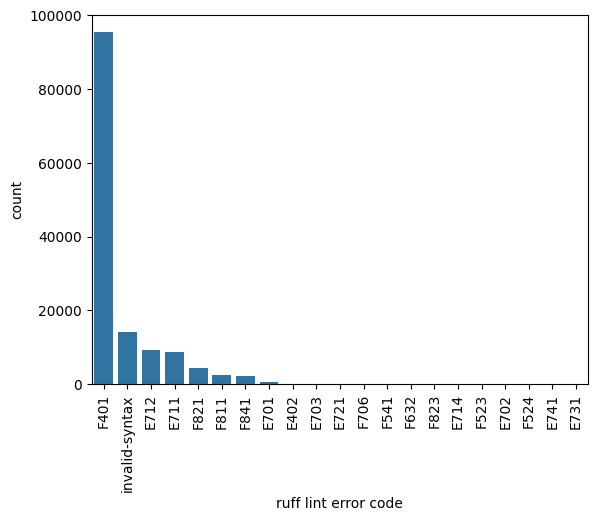

In [30]:
lint_error_codes = [row[0] for row in lint_error_counts_by_code]
lint_error_counts = [row[1] for row in lint_error_counts_by_code]
sns.barplot(x=lint_error_codes, y=lint_error_counts)
plt.xticks(rotation=90)
plt.xlabel('ruff lint error code')
plt.ylabel('count')
plt.show()

In [31]:
cursor.execute("SELECT message FROM lint_errors WHERE code = 'F401' GROUP BY message")
cursor.fetchall()

[('`collections.OrderedDict` imported but unused',),
 ('`collections.OrderedDictcd` imported but unused',),
 ('`dis` imported but unused',),
 ('`os.path` imported but unused',),
 ('`proj.ants.gui.reduce_health_decorator` imported but unused',),
 ('`tokenize.Triple` imported but unused',),
 ('`ucb.interact` imported but unused',),
 ('`ucb.main` imported but unused',),
 ('`ucb.trace` imported but unused',),
 ('`utils.random_or_none` imported but unused',)]

Since F401 is unused import which is often caused by the starter code, let's eliminate that from the analysis. (There were some students who seem to have done accidental imports that were unused, perhaps because of autocomplete or GenAI usage.)

In [32]:
lint_error_counts_by_code.pop(0)

('F401', 95443, 'https://docs.astral.sh/ruff/rules/unused-import')

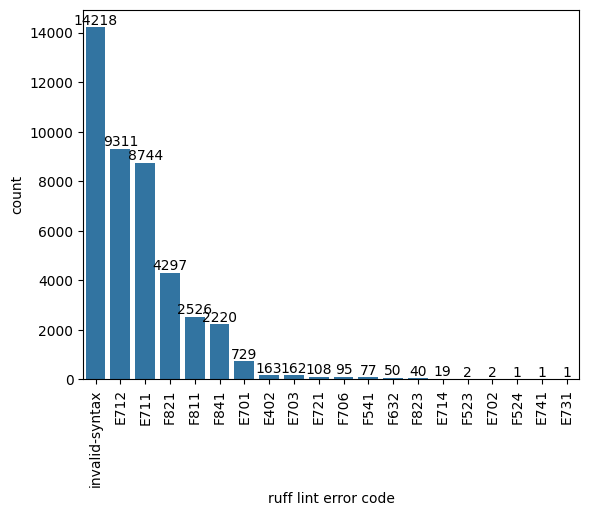

In [33]:
lint_error_codes = [row[0] for row in lint_error_counts_by_code]
lint_error_counts = [row[1] for row in lint_error_counts_by_code]
ax = sns.barplot(x=lint_error_codes, y=lint_error_counts)
# Display counts at the top of each bar
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.xlabel('ruff lint error code')
plt.ylabel('count')
plt.show()

We can see that the lint errors with at least 2000 occurrences are:

- invalid-syntax (could have many causes, see below). This is perhaps unexpected because I ran the linter on ALL backups including in-progress work
- [E712](https://docs.astral.sh/ruff/rules/true-false-comparison): true false comparison
- [E711](https://docs.astral.sh/ruff/rules/none-comparison): none comparison
- [F821](https://docs.astral.sh/ruff/rules/undefined-name): undefined name
- [F811](https://docs.astral.sh/ruff/rules/redefined-while-unused): redefined while unused
- [F841](https://docs.astral.sh/ruff/rules/unused-variable): unused variable

In [34]:
cursor.execute("""
SELECT message, COUNT(*)
FROM lint_errors
WHERE code = 'invalid-syntax'
GROUP BY message
HAVING COUNT(*) >= 20
ORDER BY COUNT(*) DESC
""")
cursor.fetchall()

[('Got unexpected token \xa0', 9448),
 ('Expected a statement', 1134),
 ('Simple statements must be separated by newlines or semicolons', 753),
 ('Unexpected indentation', 628),
 ('Expected an expression', 311),
 ('Expected `,`, found name', 281),
 ('Expected `:`, found newline', 216),
 ('Expected an indented block after `if` statement', 201),
 ('unindent does not match any outer indentation level', 151),
 ('Expected an indented block after function definition', 141),
 ('Invalid annotated assignment target', 118),
 ('Expected an identifier', 116),
 ('Expected dedent, found end of file', 68),
 ('Expected an indented block after `class` definition', 55),
 ('Expected `:`, found `=`', 53),
 ('Expected `,`, found `:`', 40),
 ('Expected an indented block after `else` clause', 37),
 ('Expected an indented block after `while` statement', 33),
 ('Expected `:`, found name', 33),
 ('missing closing quote in string literal', 24),
 ('Expected an indented block after `for` statement', 22),
 ('Expect

`Got unexpected token \xa0` is a really strange error that I would not have expected from the Ants project. `\xa0` is the unicode encoding for a [non-breaking space](https://en.wikipedia.org/wiki/Non-breaking_space), which might occur if students were copying and pasting from an HTML source because it does not occur in the Ants starter code as far as I know. (`nbsp` occurs in some of the [auxiliary Ants files](https://github.com/search?q=repo%3ACal-CS-61A-Staff%2Fberkeley-cs61a+%22nbsp%22&type=code) like the debugger (?) that I don't think I've used before...)

In [35]:
# create indexes for faster joins
cursor.execute("CREATE INDEX idx_metadata_email_created ON backup_metadata(student_email, created DESC);")
cursor.execute("CREATE INDEX idx_lint_location ON lint_errors(file_contents_location);")

In [45]:
# Number of lint errors per student on their final backup, excluding F401
cursor.execute("""
WITH last_backups AS (
    SELECT
        backup_id,
        MAX(created) AS created, -- in SQLite this works
        student_email,
        file_contents_location
    FROM backup_metadata
    GROUP BY student_email
),

backups_with_lint_errors AS (
    SELECT
        lb.backup_id,
        lb.created,
        lb.student_email,
        le.*
    FROM last_backups AS lb
    JOIN lint_errors AS le
    ON REPLACE(lb.file_contents_location, '../../data/private/', '') = REPLACE(le.file_contents_location, '/ants.py', '')
    WHERE le.code != 'F401'
)

SELECT
    student_email,
    COUNT(*)
FROM backups_with_lint_errors
GROUP BY student_email
ORDER BY COUNT(*) DESC
""")
student_to_lint_error_count = cursor.fetchall()
student_to_lint_error_count

[('ad98861e', 18),
 ('bf674fbc', 17),
 ('b30d1d3d', 15),
 ('e52d66d9', 11),
 ('a9286b6c', 11),
 ('9c561a42', 11),
 ('875cb0cd', 11),
 ('83f0d114', 10),
 ('05c11b38', 10),
 ('dc8b5216', 9),
 ('d8328d71', 9),
 ('c91b6b9a', 9),
 ('94ea236e', 8),
 ('9e72fc4e', 7),
 ('547d1da5', 7),
 ('3da25a85', 7),
 ('228021c6', 7),
 ('e1fbf17d', 6),
 ('a97024dc', 6),
 ('a40c28f7', 6),
 ('a2d00ddf', 6),
 ('89c747d1', 6),
 ('443ca939', 6),
 ('419dfa13', 6),
 ('227e6c44', 6),
 ('c6a4f30f', 5),
 ('b646d225', 5),
 ('9737fa20', 5),
 ('6fc50638', 5),
 ('640aa6b9', 5),
 ('5deafc11', 5),
 ('588f72a1', 5),
 ('44434fa4', 5),
 ('0cf1f44e', 5),
 ('f7bd99ce', 4),
 ('e216d5b6', 4),
 ('d1daaba1', 4),
 ('c3d13adf', 4),
 ('9b70ba05', 4),
 ('7d47d37f', 4),
 ('653c46fc', 4),
 ('602dccfe', 4),
 ('4b1352cf', 4),
 ('41f9b5e0', 4),
 ('1ec67d61', 4),
 ('0c7da385', 4),
 ('0659a26e', 4),
 ('f7ffd448', 3),
 ('cdd7659c', 3),
 ('c7042137', 3),
 ('c20830d6', 3),
 ('8635d213', 3),
 ('83f4472b', 3),
 ('7dcfb139', 3),
 ('6ac9b60f', 3),
 

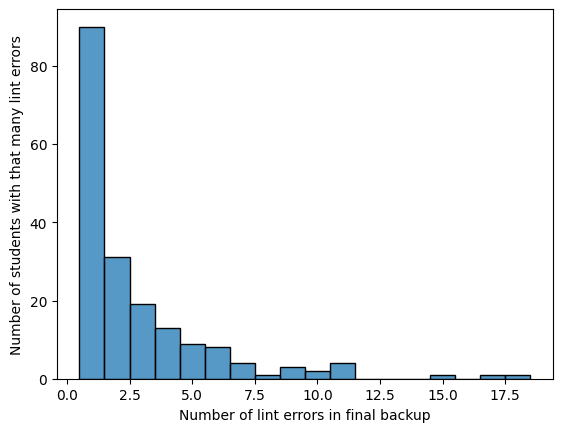

In [49]:
sns.histplot([row[1] for row in student_to_lint_error_count], discrete=True)
plt.xlabel('Number of lint errors in final backup')
plt.ylabel('Number of students with that many lint errors')
plt.show()

In [50]:
# Most common lint errors in final backup
cursor.execute("""
WITH last_backups AS (
    SELECT
        backup_id,
        MAX(created) AS created, -- in SQLite this works
        student_email,
        file_contents_location
    FROM backup_metadata
    GROUP BY student_email
),

backups_with_lint_errors AS (
    SELECT
        lb.backup_id,
        lb.created,
        lb.student_email,
        le.*
    FROM last_backups AS lb
    JOIN lint_errors AS le
    ON REPLACE(lb.file_contents_location, '../../data/private/', '') = REPLACE(le.file_contents_location, '/ants.py', '')
    WHERE le.code != 'F401'
)

SELECT code, COUNT(*)
FROM backups_with_lint_errors
GROUP BY code
ORDER BY COUNT(*) DESC
""")
common_lint_errors_final_backups = cursor.fetchall()
common_lint_errors_final_backups

[('E712', 218),
 ('E711', 177),
 ('F811', 56),
 ('F821', 26),
 ('F841', 22),
 ('E701', 21),
 ('E402', 4),
 ('invalid-syntax', 3),
 ('F541', 2),
 ('F632', 1),
 ('E703', 1)]

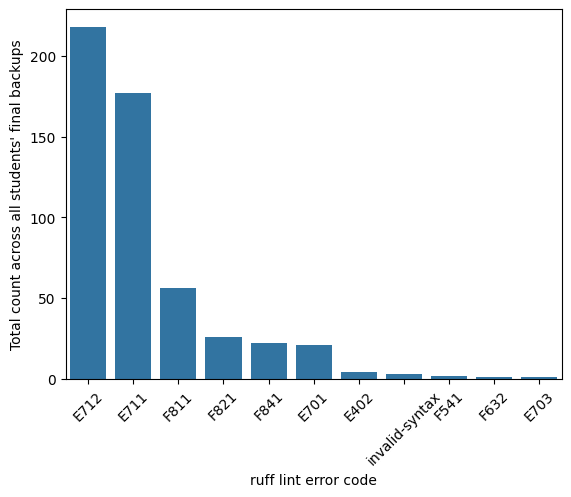

In [57]:
sns.barplot(x=[row[0] for row in common_lint_errors_final_backups], y=[row[1] for row in common_lint_errors_final_backups])
plt.xticks(rotation=45)
plt.xlabel('ruff lint error code')
plt.ylabel("Total count across all students' final backups")
plt.show()

Most common lint errors in final submission:

- E712: true false comparison (also top overall)
- E711: none comparison (also top overall)
- F811: redefined while unused (also top overall)
- F821: undefined name (also top overall)
- F841: unused variable (also top overall)
- E701: multiple statements on one line colon (would be next in top overall)

See links to examples below.

In [60]:
def create_ruff_url(code: str) -> str:
    return f'https://docs.astral.sh/ruff/rules/{code}'

list(map(create_ruff_url, [row[0] for row in common_lint_errors_final_backups]))

['https://docs.astral.sh/ruff/rules/E712',
 'https://docs.astral.sh/ruff/rules/E711',
 'https://docs.astral.sh/ruff/rules/F811',
 'https://docs.astral.sh/ruff/rules/F821',
 'https://docs.astral.sh/ruff/rules/F841',
 'https://docs.astral.sh/ruff/rules/E701',
 'https://docs.astral.sh/ruff/rules/E402',
 'https://docs.astral.sh/ruff/rules/invalid-syntax',
 'https://docs.astral.sh/ruff/rules/F541',
 'https://docs.astral.sh/ruff/rules/F632',
 'https://docs.astral.sh/ruff/rules/E703']

## Number of lines

In [3]:
cursor.execute("""
WITH backup_line_counts AS (
    SELECT
        m.student_email,
        m.course,
        m.assignment,
        m.created,
        f.file_name,
        f.num_lines
    FROM backup_metadata AS m
    JOIN backup_file_metadata AS f
    ON m.file_contents_location = f.file_contents_location
),

consecutive_changes AS (
    -- Step 2: Use LAG to find the line count of the previous backup
    SELECT
        student_email,
        course,
        assignment,
        created,
        file_name,
        num_lines AS current_lines,
        LAG(num_lines) OVER (
            PARTITION BY student_email, course, assignment, file_name
            ORDER BY created ASC
        ) AS prev_lines
    FROM backup_line_counts
),

-- each row is a student's backup with line diff count
line_diffs AS (
    SELECT
        student_email,
        course,
        assignment,
        file_name,
        created,
        current_lines,
        prev_lines,
        -- for first backup, there is no prev_lines
        (current_lines - IFNULL(prev_lines, current_lines)) AS lines_diff
    FROM consecutive_changes
    ORDER BY student_email, created ASC
)

SELECT
    student_email,
    AVG(lines_diff)
FROM line_diffs
GROUP BY student_email
ORDER BY AVG(lines_diff) DESC, student_email
""")
line_diffs = cursor.fetchall()
line_diffs[:5]

[('d03802a0', 18.97826086956522),
 ('46d94ead', 10.88888888888889),
 ('da45f072', 7.066666666666666),
 ('8635d213', 7.0),
 ('603d85e7', 5.421052631578948)]

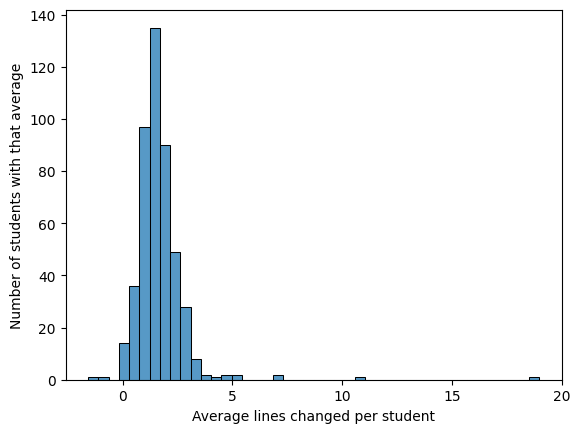

In [4]:
sns.histplot([row[1] for row in line_diffs])
plt.xlabel("Average lines changed per student")
plt.ylabel("Number of students with that average")
plt.show()

In [5]:
np.median(np.array([row[1] for row in line_diffs]))

np.float64(1.5148706896551722)

In [6]:
np.std(np.array([row[1] for row in line_diffs]))

np.float64(1.2571025656551733)

In [7]:
np.random.seed(42)

In [14]:
# Choose random student email
random_student_email = str(np.random.choice([row[0] for row in line_diffs]))
random_student_email

'443ca939'

In [15]:
# Look at the "journey" of one particular student - when do students make changes?
cursor.execute(f"""
WITH backup_line_counts AS (
    SELECT
        m.student_email,
        m.course,
        m.assignment,
        m.created,
        f.file_name,
        f.num_lines
    FROM backup_metadata AS m
    JOIN backup_file_metadata AS f
    ON m.file_contents_location = f.file_contents_location
),

consecutive_changes AS (
    -- Step 2: Use LAG to find the line count of the previous backup
    SELECT
        student_email,
        course,
        assignment,
        created,
        file_name,
        num_lines AS current_lines,
        LAG(num_lines) OVER (
            PARTITION BY student_email, course, assignment, file_name
            ORDER BY created ASC
        ) AS prev_lines
    FROM backup_line_counts
),

-- each row is a student's backup with line diff count
line_diffs AS (
    SELECT
        student_email,
        course,
        assignment,
        file_name,
        created,
        current_lines,
        prev_lines,
        -- for first backup, there is no prev_lines
        (current_lines - IFNULL(prev_lines, current_lines)) AS lines_diff
    FROM consecutive_changes
    ORDER BY student_email, created ASC
)

SELECT *
FROM line_diffs
WHERE student_email = '{random_student_email}'
ORDER BY created
""")
random_student_line_diffs = cursor.fetchall()
random_student_line_diffs[:5]

[('443ca939',
  'cal/cs88/fa25',
  'ants',
  'ants.py',
  '2025-11-05T19:17:01',
  798,
  None,
  0),
 ('443ca939',
  'cal/cs88/fa25',
  'ants',
  'ants.py',
  '2025-11-05T19:25:34',
  801,
  798,
  3),
 ('443ca939',
  'cal/cs88/fa25',
  'ants',
  'ants.py',
  '2025-11-05T19:25:46',
  801,
  801,
  0),
 ('443ca939',
  'cal/cs88/fa25',
  'ants',
  'ants.py',
  '2025-11-06T02:27:57',
  802,
  801,
  1),
 ('443ca939',
  'cal/cs88/fa25',
  'ants',
  'ants.py',
  '2025-11-06T02:28:15',
  802,
  802,
  0)]

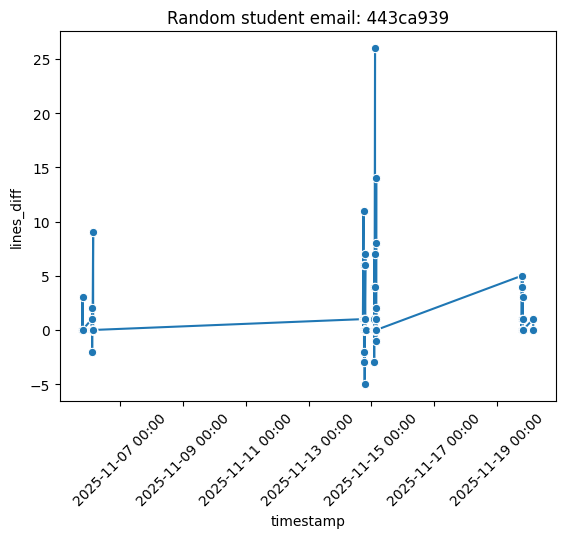

In [16]:
data = {
    'timestamp': [row[4] for row in random_student_line_diffs],
    'lines_diff': [row[7] for row in random_student_line_diffs],
}
df = pd.DataFrame(data)

df['timestamp'] = pd.to_datetime(df['timestamp'])

ax = sns.lineplot(data=df, x='timestamp', y='lines_diff', marker='o')

# Force the same date format in the plot
date_formatter = mdates.DateFormatter('%Y-%m-%d %H:%M')
ax.xaxis.set_major_formatter(date_formatter)

plt.xticks(rotation=45)
plt.title(f"Random student email: {random_student_email}")
plt.show()

## Print debugging

In [31]:
def count_search_string_in_file(path, search_string):
    with open(path, 'r') as f:
        contents = f.read()
        return contents.count(search_string)

In [32]:
cursor.execute("""
SELECT backup_id, student_email, created, file_contents_location || '/ants.py' AS file_contents_location
FROM backup_metadata
""")
file_paths = cursor.fetchall()
file_paths[0]

('o7g7AA',
 '9ef88296',
 '2025-11-23T03:47:48',
 '../../data/private/cal/cs88/fa25/ants/9ef88296/o7g7AA/ants.py')

In [33]:
print_debug_data = {
    # TODO find out why there is a path that is None
    'backup_id': [row[0] for row in file_paths if row[3]],
    'student_email': [row[1] for row in file_paths if row[3]],
    'created': [row[2] for row in file_paths if row[3]],
    'num_occurrences_print': []
}

for path in [row[3] for row in file_paths]:
    if path: # TODO find out why there is a path that is None
        print_debug_data['num_occurrences_print'].append(count_search_string_in_file(path, 'print'))

In [34]:
print_debug_data_df = pd.DataFrame(print_debug_data)
print_debug_data_df['created'] = pd.to_datetime(print_debug_data_df['created'])
print_debug_data_df.head()

,backup_id,student_email,created,num_occurrences_print
0,o7g7AA,9ef88296,2025-11-23 03:47:48,3
1,mG9G7E,9ef88296,2025-11-23 03:47:37,3
2,lD9D87,9ef88296,2025-11-23 03:47:21,3
3,7OBOD8,9ef88296,2025-11-23 03:46:34,3
4,53z3lq,9ef88296,2025-11-23 03:46:07,3


In [35]:
# Choose random student email
random_student_email = str(np.random.choice([row[0] for row in line_diffs]))
random_student_email

'abc1c76b'

In [36]:
random_student_print_debug = print_debug_data_df[print_debug_data_df['student_email'] == random_student_email]
random_student_print_debug.head()

,backup_id,student_email,created,num_occurrences_print
31272,Zp9PKE,abc1c76b,2025-11-29 05:18:18,3
31273,Y09OJ9,abc1c76b,2025-11-29 05:18:12,3
31274,mG9rWA,abc1c76b,2025-11-29 05:12:15,3
31275,lD9qWJ,abc1c76b,2025-11-29 05:12:07,3
31276,EGVnVN,abc1c76b,2025-11-29 05:02:54,3


From random sampling manual observation: A lot of people always have 3 print statements the entire time.

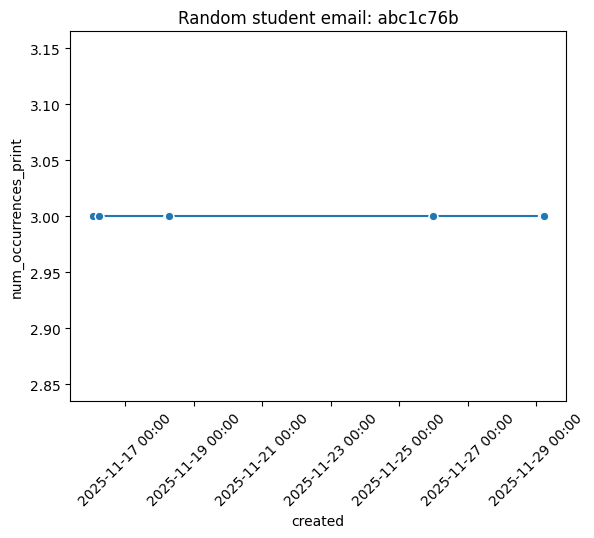

In [37]:
ax = sns.lineplot(data=random_student_print_debug, x='created', y='num_occurrences_print', marker='o')

# Force the same date format in the plot
date_formatter = mdates.DateFormatter('%Y-%m-%d %H:%M')
ax.xaxis.set_major_formatter(date_formatter)

plt.xticks(rotation=45)
plt.title(f"Random student email: {random_student_email}")
plt.show()

## Teardown

In [29]:
# Close db connection
conn.close()

# TODO Questions

file contents:

- how many students used print debugging?
- how many students used print("DEBUG: ...")
- how many students used print debugging successfully? (file contents had `print` somewhere and following backup passed more or all tests?)


.json data:

- How many backups corresponded to each problem?
- How much time was spent working on each problem?


- Average # of lines added from first backup to last backup?
- How many lines change between backups (summary statistics)?


- Do students typically do unlocking tests before? How many attempts does it take vs. getting everything 100% on first try?